<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/Library_Simplify_ProductionML_1027_%EB%8F%8C%EC%95%84%EA%B0%91%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Generation

- **Two dataset types**
  1. **K-intensive**
     - $K \sim U(0,1)$
     - $L = 0$
  2. **L-intensive**
     - $K = 0$
     - $L \sim U(0,1)$

- **Three target functions (each with noise)**
  1. $y = K^3 + \epsilon$
  2. $y = -K^3 + \epsilon$
  3. $y = L^3 + \epsilon$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# === 1. Data ===
np.random.seed(42)
tf.random.set_seed(42)

n = 1000
noise_scale = 0.05

# K-intensive: K~U(0,1), L=0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K=0, L~U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3 + np.random.normal(0, noise_scale, size=(n, 1))      # K³ + noise
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))     # −K³ + noise
y3 = L**3 + np.random.normal(0, noise_scale, size=(n, 1))      # L³ + noise
y4 = -L**3 + np.random.normal(0, noise_scale, size=(n, 1))


## Build & Train Model

### Build Original Model

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda

# Original Model - 5 layer trained on y1
def build_model():
    model = Sequential([
        tf.keras.Input(shape=(2,)),
        Lambda(tf.nn.relu, name="input_relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

model = build_model()
model.fit(X_K, y1, epochs=100, batch_size=32, verbose=0)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_relu (Lambda)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533 (2.09 KB)

 Trainable params: 177 (708.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 356 (1.39 KB)

### Build TL Models

In [4]:
# TL Model 1 - Train on y1 data -> Transfer Learning to y2 data (last 2 layers)
model_tf_y2 = Sequential()
for i in range(3):
    layer = model.layers[i]
    layer.trainable = False
    model_tf_y2.add(layer)

model_tf_y2.add(Dense(8, activation="relu"))
model_tf_y2.add(Dense(1))
model_tf_y2.compile(optimizer="adam", loss="mse")

model_tf_y2.fit(X_K, y2, verbose=0, epochs=100, batch_size=32)

# TL Model 2 - Train on y1 data -> Transfer Learning to y3 data (last 2 layers)
model_tf_y3 = Sequential()
for i in range(3):
    layer = model.layers[i]
    layer.trainable = False
    model_tf_y3.add(layer)

model_tf_y3.add(Dense(8, activation="relu"))
model_tf_y3.add(Dense(1))
model_tf_y3.compile(optimizer="adam", loss="mse")

model_tf_y3.fit(X_L, y3, verbose=0, epochs=100, batch_size=32)

### Train on y1(K-intensive) 10 times

See what happens if the NN model encounters data on production functions with untrained parameters.

(Only trained on K -> predict data on L)

In [5]:
# ---------- Train 10 independent models on y1, evaluate on L ----------
n_trials = 10
L_preds = []

for t in range(n_trials):
    print(f"[Trial {t+1}/{n_trials}] training on y1 ...")
    m = build_model()
    m.fit(X_K, y1, epochs=50, batch_size=32, verbose=0)  # train ONLY on y1
    L_pred_t = m.predict(X_L, verbose=0).ravel()
    L_preds.append(L_pred_t)

L_preds = np.vstack(L_preds)                             # shape (10, N)
L_true_1d = y3.ravel()
K0_1d = K0.ravel()
L_1d  = L.ravel()

mse_all = (L_preds - L_true_1d)**2                      # (10, N)
vmin, vmax = 0.0, 1.0

[Trial 1/10] training on y1 ...
[Trial 2/10] training on y1 ...
[Trial 3/10] training on y1 ...
[Trial 4/10] training on y1 ...
[Trial 5/10] training on y1 ...
[Trial 6/10] training on y1 ...
[Trial 7/10] training on y1 ...
[Trial 8/10] training on y1 ...
[Trial 9/10] training on y1 ...
[Trial 10/10] training on y1 ...


### Data Visualization (y1, y2, y3)

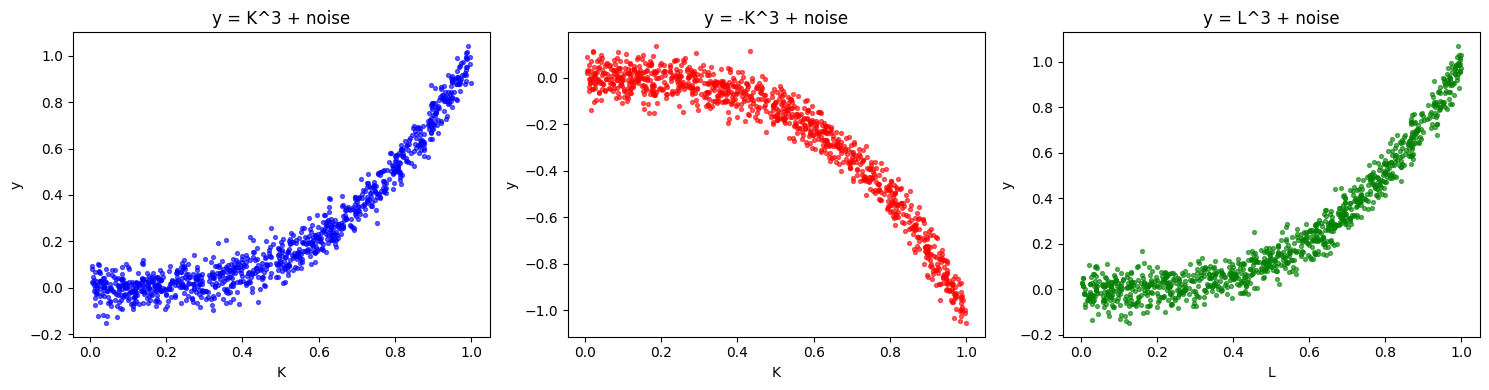

In [7]:
# ===== Visualization =====
fig, axs = plt.subplots(1, 3, figsize=(15,4))

# 1. y = K^3
axs[0].scatter(K, y1, color="blue", s=8, alpha=0.6, label="K intensive")
axs[0].set_title("y = K^3 + noise")
axs[0].set_xlabel("K")
axs[0].set_ylabel("y")

# 2. y = -K^3
axs[1].scatter(K, y2, color="red", s=8, alpha=0.6, label="K intensive")
axs[1].set_title("y = -K^3 + noise")
axs[1].set_xlabel("K")
axs[1].set_ylabel("y")

# 3. y = L^3
axs[2].scatter(L, y3, color="green", s=8, alpha=0.6, label="L intensive")
axs[2].set_title("y = L^3 + noise")
axs[2].set_xlabel("L")
axs[2].set_ylabel("y")

plt.tight_layout()
plt.show()